## required libraries importing

In [502]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

## reading dataset and take a look at it and its information

In [458]:
d = pd.read_csv('googleplaystore.csv')
d.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [459]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [460]:
d.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


## some initial analysis about values in each column

because some numerical features are saved as strings and there are many irrelevant values, 

before calculating correlation of features we have to do some clean-ups

In [461]:
print(d['App'].value_counts())
print('\n')
print(d['Category'].value_counts())
print('\n')
print(d['Rating'].value_counts())
print('\n')
print(d['Reviews'].value_counts())
print('\n')
print(d['Size'].value_counts())
print('\n')
print(d['Installs'].value_counts())
print('\n')
print(d['Type'].value_counts())
print('\n')
print(d['Price'].value_counts())
print('\n')
print(d['Content Rating'].value_counts())
print('\n')
print(d['Genres'].value_counts())

ROBLOX                                                9
CBS Sports App - Scores, News, Stats & Watch Live     8
ESPN                                                  7
Duolingo: Learn Languages Free                        7
Candy Crush Saga                                      7
                                                     ..
Meet U - Get Friends for Snapchat, Kik & Instagram    1
U-Report                                              1
U of I Community Credit Union                         1
Waiting For U Launcher Theme                          1
iHoroscope - 2018 Daily Horoscope & Astrology         1
Name: App, Length: 9660, dtype: int64


FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRA

In [462]:
# there is an unusual row that should be removed
d.drop(index=d[d['Reviews']=='3.0M'].index,inplace=True)

In [463]:
# there are rows with values that are not informative
np.sum(d=='Varies with device')

App                  0
Category             0
Rating               0
Reviews              0
Size              1695
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver       1459
Android Ver       1362
dtype: int64

In [464]:
# these not informative lines are dropped
d.drop(index=d[d['Size']=='Varies with device'].index,inplace=True)
np.sum(d=='Varies with device')

App                0
Category           0
Rating             0
Reviews            0
Size               0
Installs           0
Type               0
Price              0
Content Rating     0
Genres             0
Last Updated       0
Current Ver       73
Android Ver       56
dtype: int64

In [465]:
d.drop(index=d[d['Current Ver']=='Varies with device'].index,inplace=True)
np.sum(d=='Varies with device')

App                0
Category           0
Rating             0
Reviews            0
Size               0
Installs           0
Type               0
Price              0
Content Rating     0
Genres             0
Last Updated       0
Current Ver        0
Android Ver       13
dtype: int64

In [466]:
d.drop(index=d[d['Android Ver']=='Varies with device'].index,inplace=True)
np.sum(d=='Varies with device')

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

In [467]:
# some numerical values are saved as strings that should be converted
d['Reviews'] = d['Reviews'].astype('int')

In [468]:
def func1(x):
    if 'M' in x:
        return 1e6*float(x[:-1])
    elif 'k' in x:
        return 1e3*float(x[:-1])
    else:
        return float(x)

In [469]:
d['Size'] = d['Size'].apply(func1)

In [470]:
d['Installs'] = d['Installs'].apply(lambda x:int(x[:-1].replace(',','')))

In [471]:
d['Price'] = d['Price'].apply(lambda x:int(x) if x=='0' else float(x[1:]))

In [489]:
d.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,high rating
0,ART_AND_DESIGN,4.1,159,19000000.0,10000,Free,0.0,Everyone,Art & Design,1
1,ART_AND_DESIGN,3.9,967,14000000.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,0
2,ART_AND_DESIGN,4.7,87510,8700000.0,5000000,Free,0.0,Everyone,Art & Design,1
4,ART_AND_DESIGN,4.3,967,2800000.0,100000,Free,0.0,Everyone,Art & Design;Creativity,1
5,ART_AND_DESIGN,4.4,167,5600000.0,50000,Free,0.0,Everyone,Art & Design,1


## correlation matrix of numercial features 

In [473]:
d.corr()

,Rating,Reviews,Size,Installs,Price
Rating,1.000000,0.079742,0.084090,0.052127,-0.021251
Reviews,0.079742,1.000000,0.238573,0.637016,-0.009782
Size,0.084090,0.238573,1.000000,0.162114,-0.022855
Installs,0.052127,0.637016,0.162114,1.000000,-0.010321
Price,-0.021251,-0.009782,-0.022855,-0.010321,1.000000


## removing some irrelevant columns

In [474]:
# some feature are not relevant, so they are removed
d.drop(columns=['App','Current Ver','Android Ver','Last Updated'],inplace=True)

## take a look at info again and NA value filling

In [475]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9059 entries, 0 to 10838
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        9059 non-null   object 
 1   Rating          7643 non-null   float64
 2   Reviews         9059 non-null   int32  
 3   Size            9059 non-null   float64
 4   Installs        9059 non-null   int64  
 5   Type            9059 non-null   object 
 6   Price           9059 non-null   float64
 7   Content Rating  9059 non-null   object 
 8   Genres          9059 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(4)
memory usage: 672.3+ KB


In [476]:
imp = SimpleImputer(strategy='most_frequent')
d['Rating'] = imp.fit_transform(d['Rating'].to_numpy().reshape(-1,1))

C:\Users\Fani\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [477]:
d['Rating'].isna().sum()

0

## new column definition as target value for classification section

high rating that can be 'yes' or 'no' with predefined threshold of 3.9 

In [478]:
d['high rating'] = (d['Rating']>3.9).astype('int')

# some informative plots about feature relevance to target values: "rating" and "high rating"

## numerical features relevance to high rating 

<AxesSubplot:xlabel='high rating', ylabel='Price'>

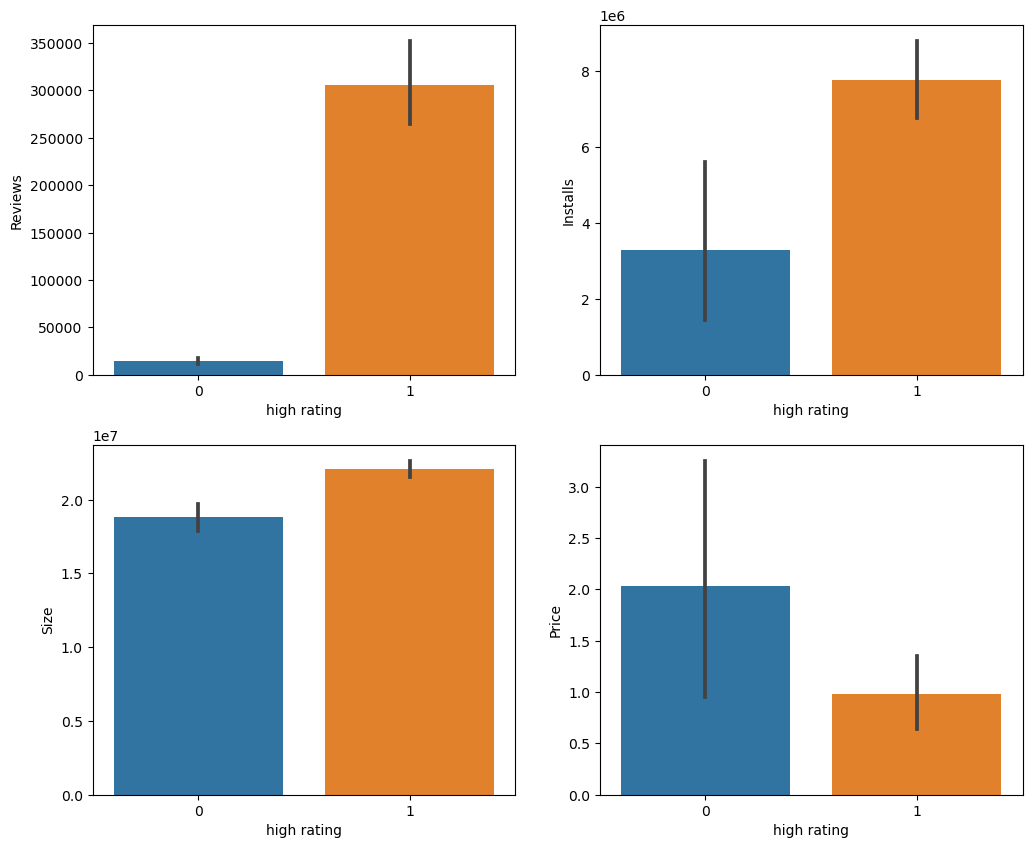

In [479]:
fig,ax = plt.subplots(2,2,figsize=[12,10])
sns.barplot(x='high rating',y='Reviews',data=d, ax=ax[0,0])
sns.barplot(x='high rating',y='Installs',data=d, ax=ax[0,1])
sns.barplot(x='high rating',y='Size',data=d, ax=ax[1,0])
sns.barplot(x='high rating',y='Price',data=d, ax=ax[1,1])

## categorical features relevance to high rating 

<AxesSubplot:xlabel='Type', ylabel='count'>

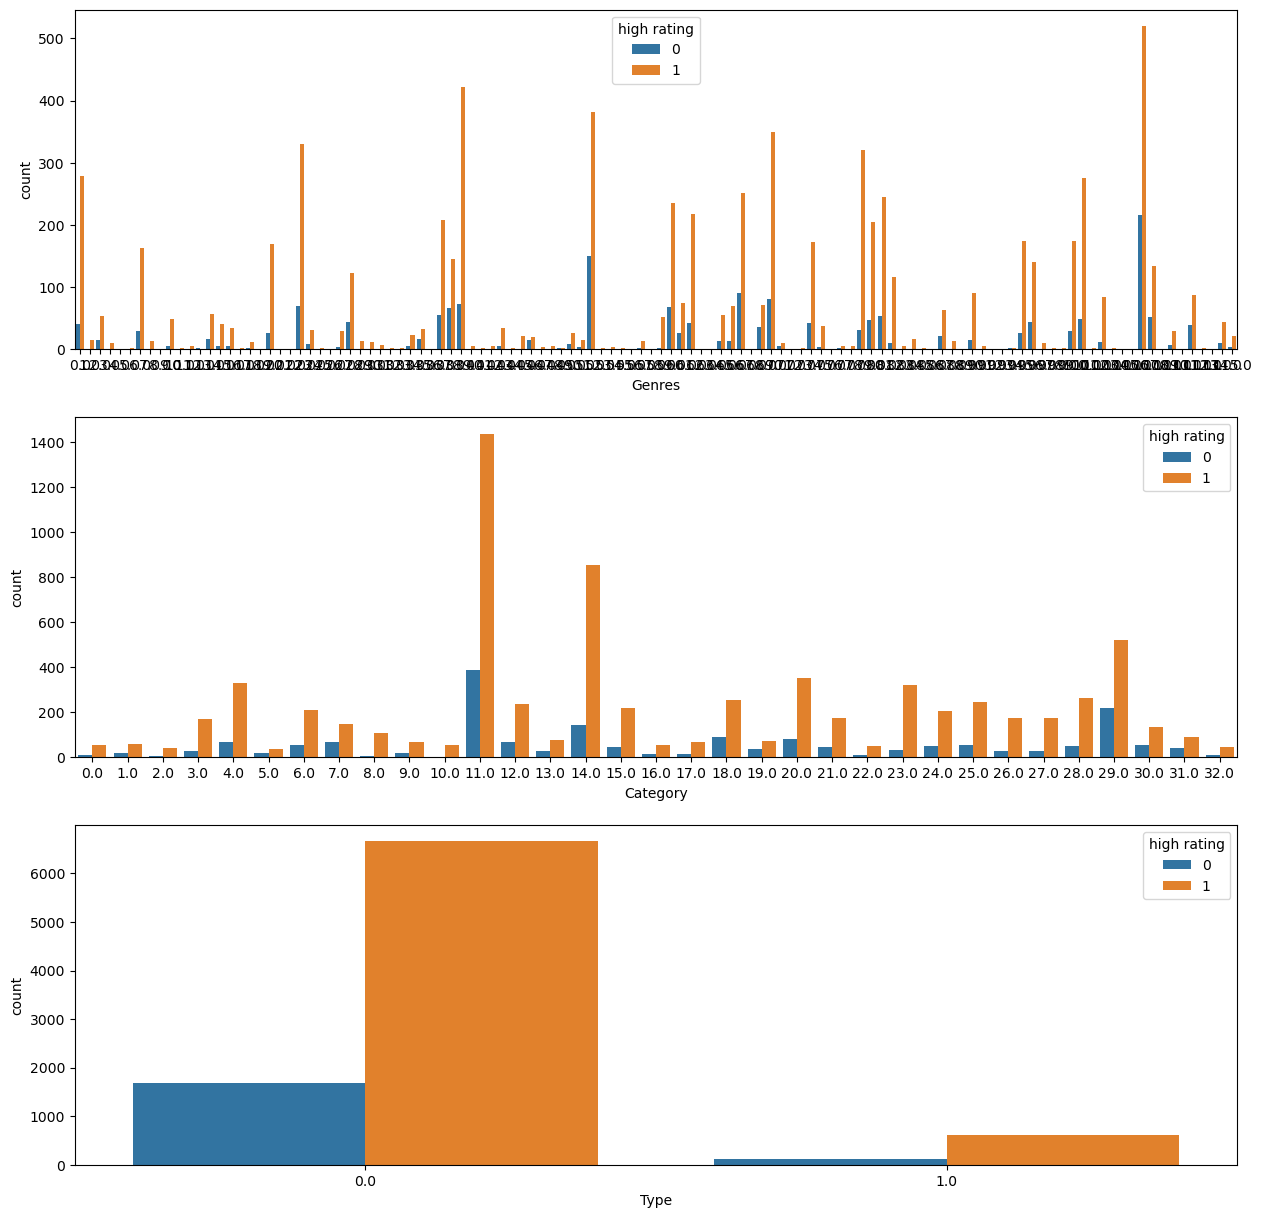

In [492]:
fig,ax = plt.subplots(3,1,figsize=[15,15])
sns.countplot(x='Genres',data=d1,hue='high rating',ax=ax[0])
sns.countplot(x='Category',data=d1,hue='high rating', ax=ax[1])
sns.countplot(x='Type',data=d1,hue='high rating', ax=ax[2])

## features relevance to rating 

<AxesSubplot:xlabel='Price', ylabel='Rating'>

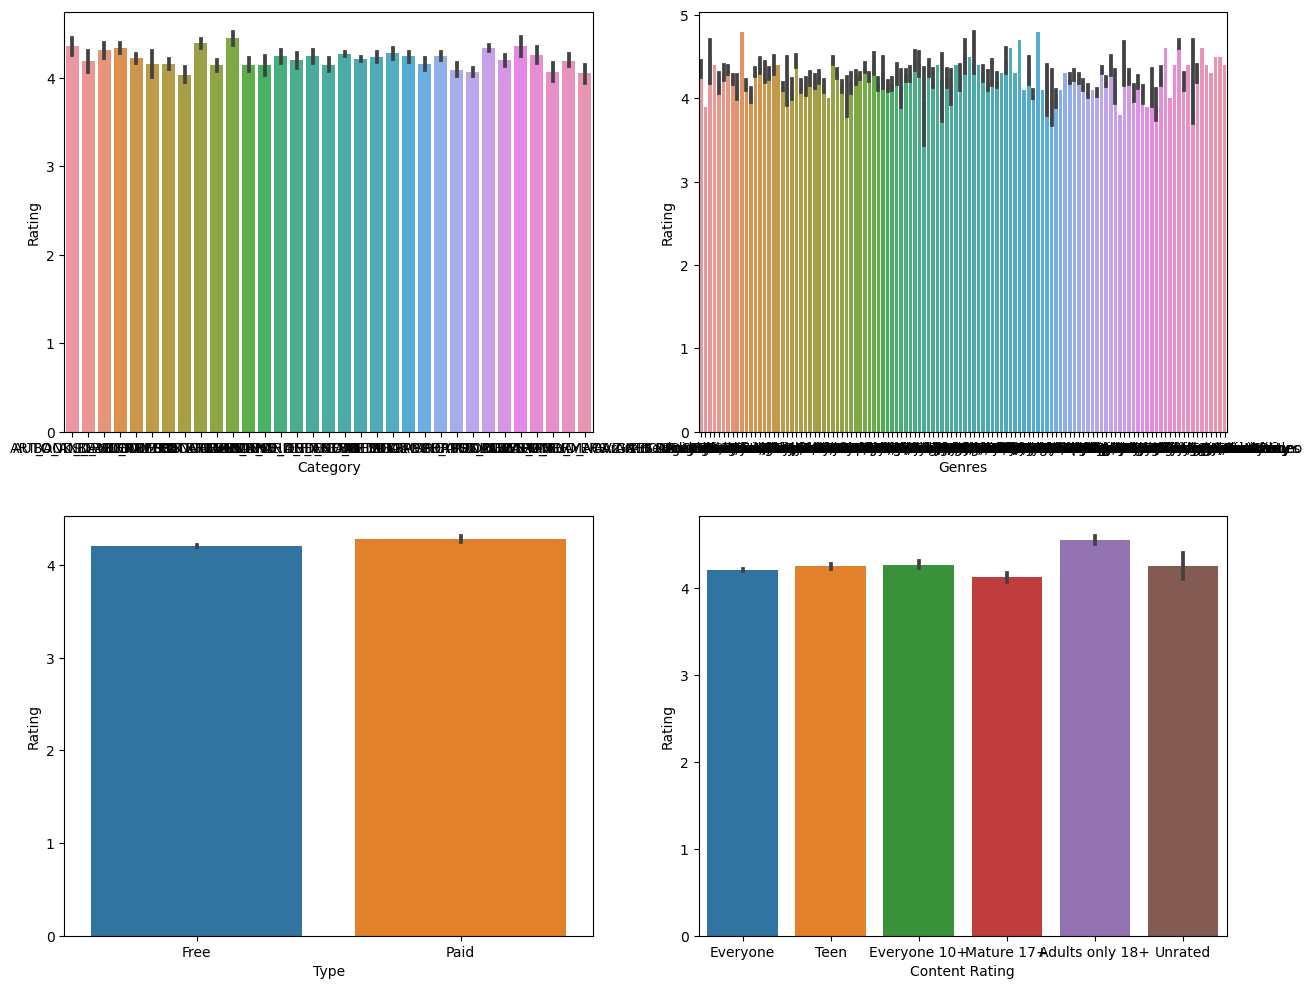

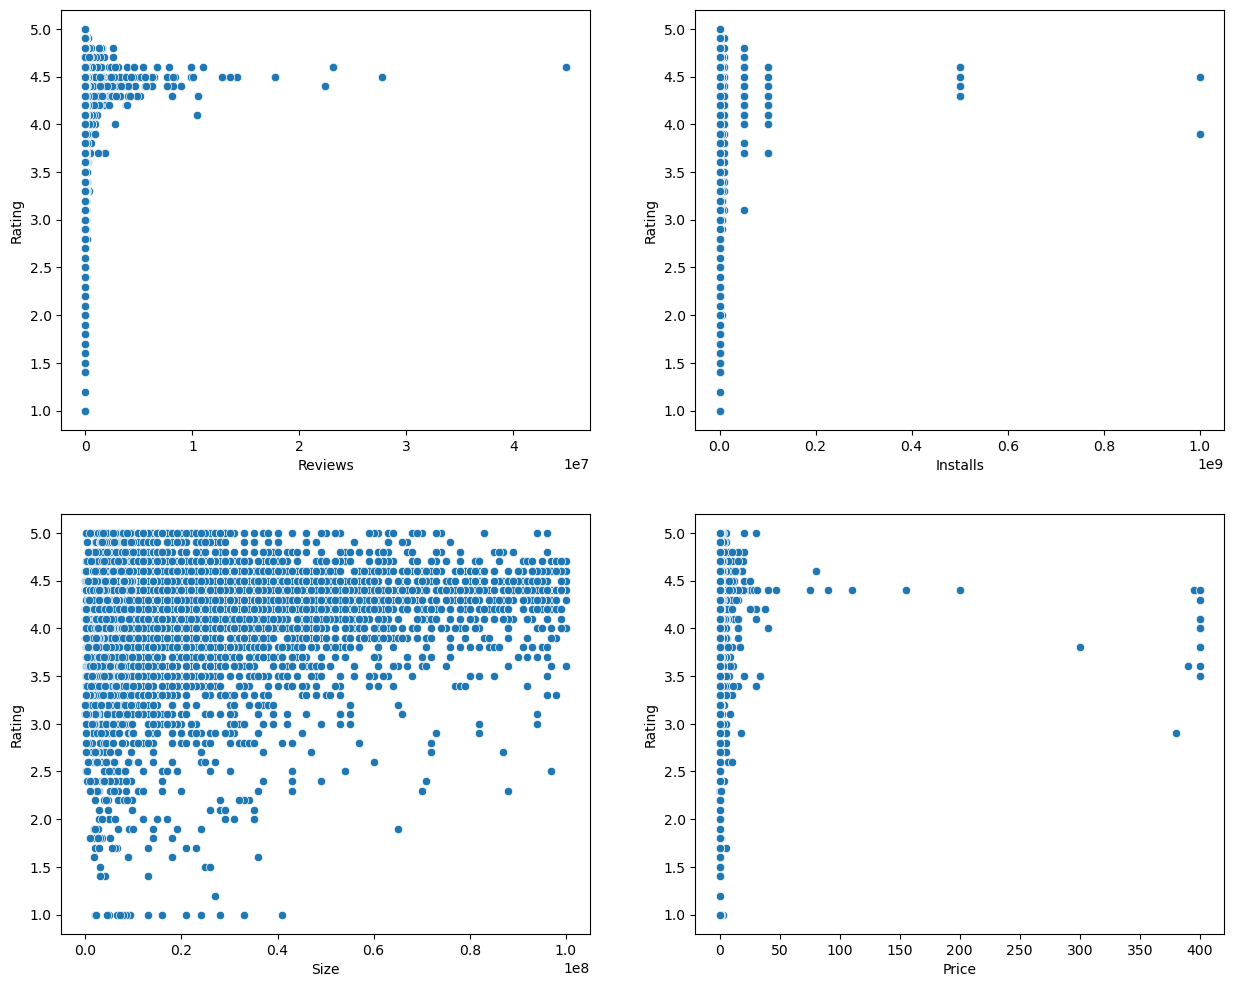

In [498]:
fig,ax = plt.subplots(2,2,figsize=[15,12])
sns.barplot(x='Category',y='Rating',data=d, ax=ax[0,0])
sns.barplot(x='Genres',y='Rating',data=d, ax=ax[0,1])
sns.barplot(x='Type',y='Rating',data=d, ax=ax[1,0])
sns.barplot(x='Content Rating',y='Rating',data=d, ax=ax[1,1])

fig,ax = plt.subplots(2,2,figsize=[15,12])
sns.scatterplot(x='Reviews',y='Rating',data=d, ax=ax[0,0])
sns.scatterplot(x='Installs',y='Rating',data=d, ax=ax[0,1])
sns.scatterplot(x='Size',y='Rating',data=d, ax=ax[1,0])
sns.scatterplot(x='Price',y='Rating',data=d, ax=ax[1,1])

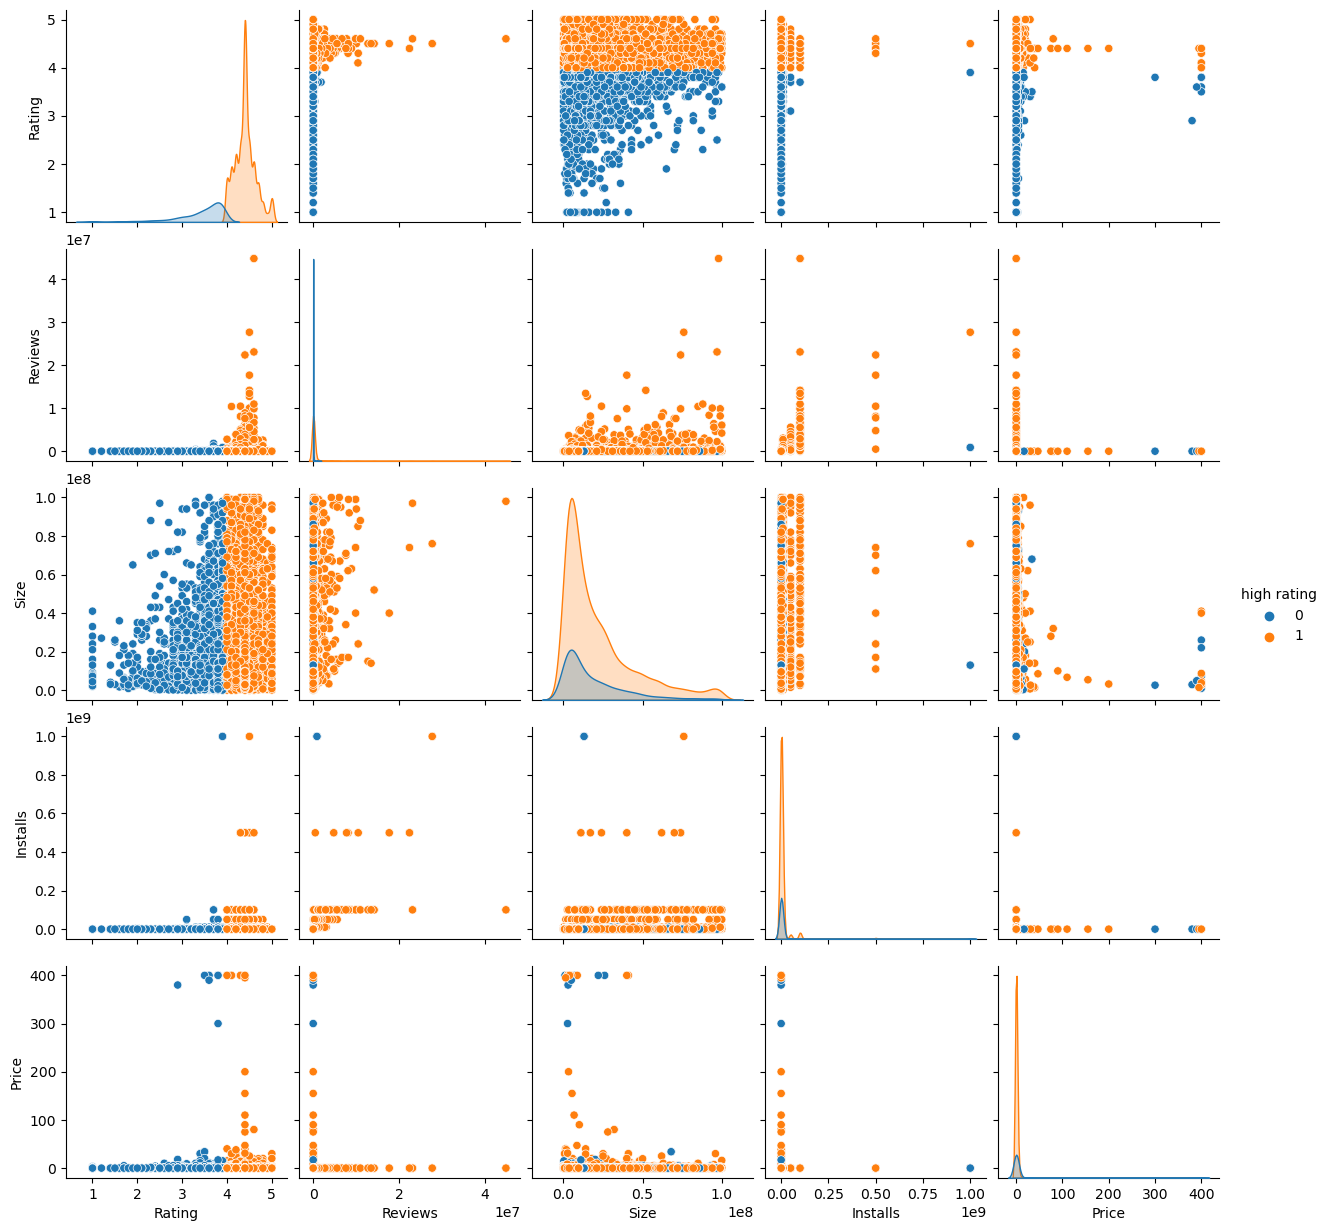

In [481]:
sns.pairplot(data=d,hue='high rating')

# classification and regression modeling

## categorical feature conversion and feature-target values seperation

In [499]:
def ordinalEncoder(df):
    encoder = OrdinalEncoder()
    d = df.select_dtypes(include=['bool','object'])
    d.loc[:,:] = encoder.fit_transform(d)
    return pd.concat([df.select_dtypes(exclude=['bool','object']),d],axis=1)
y = d['high rating']
X = ordinalEncoder(d.drop(columns=['Rating','high rating']))

## feature selection by p-value ranking

In [500]:
def chiFeaSelect(X,y,s):
    stats,pval = chi2(X,y)
    return X.loc[:,pval<s]
X = chiFeaSelect(X,y,0.005)

## classification

In [512]:
# simple train test method
# scaler initialization
scaler = StandardScaler()

# train test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# scaling only train data (to avoid data leakage)
X_train = scaler.fit_transform(X_train)

# models definition
model1 = RandomForestClassifier(n_estimators=200)
model2 = LogisticRegression()
model3 = SVC(kernel='linear')
model4 = KNeighborsClassifier(n_neighbors=5)
model5 = DecisionTreeClassifier()

# models training
model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)
model4.fit(X_train,y_train)
model5.fit(X_train,y_train)

# models testing
y_pred1 = model1.predict(scaler.transform(X_test))
y_pred2 = model2.predict(scaler.transform(X_test))
y_pred3 = model3.predict(scaler.transform(X_test))
y_pred4 = model4.predict(scaler.transform(X_test))
y_pred5 = model5.predict(scaler.transform(X_test))

# models performance report
print(f'classification report for random forest model is:\n {classification_report(y_test,y_pred1)}')
print(f'confusion matrix is:\n {confusion_matrix(y_test,y_pred1)}')
print(f'classification report for logistic regression model is:\n {classification_report(y_test,y_pred2)}')
print(f'confusion matrix is:\n {confusion_matrix(y_test,y_pred2)}')
print(f'classification report for SVM model is:\n {classification_report(y_test,y_pred3)}')
print(f'confusion matrix is:\n {confusion_matrix(y_test,y_pred3)}')
print(f'classification report for KNN is:\n {classification_report(y_test,y_pred4)}')
print(f'confusion matrix is:\n {confusion_matrix(y_test,y_pred4)}')
print(f'classification report for decision tree model is:\n {classification_report(y_test,y_pred5)}')
print(f'confusion matrix is:\n {confusion_matrix(y_test,y_pred5)}')

C:\Users\Fani\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


classification report for random forest model is:
               precision    recall  f1-score   support

           0       0.51      0.26      0.34       531
           1       0.84      0.94      0.89      2187

    accuracy                           0.81      2718
   macro avg       0.67      0.60      0.61      2718
weighted avg       0.77      0.81      0.78      2718

confusion matrix is:
 [[ 136  395]
 [ 133 2054]]
classification report for logistic regression model is:
               precision    recall  f1-score   support

           0       1.00      0.00      0.01       531
           1       0.81      1.00      0.89      2187

    accuracy                           0.81      2718
   macro avg       0.90      0.50      0.45      2718
weighted avg       0.84      0.81      0.72      2718

confusion matrix is:
 [[   2  529]
 [   0 2187]]
classification report for SVM model is:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

C:\Users\Fani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [519]:
# model testing with cross validation
# scaling whole features
X1 = scaler.fit_transform(X)

# models definition
model1 = RandomForestClassifier(n_estimators=200)
model2 = LogisticRegression()
model3 = SVC(kernel='linear')
model4 = KNeighborsClassifier(n_neighbors=5)
model5 = DecisionTreeClassifier()

# cross validating with 5-fold structure
y_pred1 = cross_val_predict(model1,X1,y,cv=5)
y_pred2 = cross_val_predict(model2,X1,y,cv=5)
y_pred3 = cross_val_predict(model3,X1,y,cv=5)
y_pred4 = cross_val_predict(model4,X1,y,cv=5)
y_pred5 = cross_val_predict(model5,X1,y,cv=5)

# models performance report
print(f'classification report for random forest model is:\n {classification_report(y,y_pred1)}')
print(f'confusion matrix is:\n {confusion_matrix(y,y_pred1)}')
print(f'classification report for logistic regression model is:\n {classification_report(y,y_pred2)}')
print(f'confusion matrix is:\n {confusion_matrix(y,y_pred2)}')
print(f'classification report for SVM model is:\n {classification_report(y,y_pred3)}')
print(f'confusion matrix is:\n {confusion_matrix(y,y_pred3)}')
print(f'classification report for KNN is:\n {classification_report(y,y_pred4)}')
print(f'confusion matrix is:\n {confusion_matrix(y,y_pred4)}')
print(f'classification report for decision tree model is:\n {classification_report(y,y_pred5)}')
print(f'confusion matrix is:\n {confusion_matrix(y,y_pred5)}')

C:\Users\Fani\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Fani\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

classification report for random forest model is:
               precision    recall  f1-score   support

           0       0.36      0.23      0.28      1791
           1       0.83      0.90      0.86      7268

    accuracy                           0.77      9059
   macro avg       0.59      0.56      0.57      9059
weighted avg       0.73      0.77      0.75      9059

confusion matrix is:
 [[ 406 1385]
 [ 719 6549]]
classification report for logistic regression model is:
               precision    recall  f1-score   support

           0       0.36      0.00      0.00      1791
           1       0.80      1.00      0.89      7268

    accuracy                           0.80      9059
   macro avg       0.58      0.50      0.45      9059
weighted avg       0.72      0.80      0.71      9059

confusion matrix is:
 [[   4 1787]
 [   7 7261]]
classification report for SVM model is:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00 

## regression

In [521]:
# Regression without scaling
# train test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# model definition
model1 = LinearRegression()
model2 = SGDRegressor()
model3 = GradientBoostingRegressor()

# model training
model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

# model testing
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

print(f'linear regression model score is:\n{model1.score(X_test,y_test)}')
print(f'MSE is:\n{mean_squared_error(y_test,y_pred1,squared=False)}\n')

print(f'stochastic gradient descent model score is:\n{model2.score(X_test,y_test)}')
print(f'MSE is:\n{mean_squared_error(y_test,y_pred2,squared=False)}\n')

print(f'gradient boosting regression model score is:\n{model3.score(X_test,y_test)}')
print(f'MSE is:\n{mean_squared_error(y_test,y_pred3,squared=False)}\n')

linear regression model score is:
0.008605808491683686
MSE is:
0.3947711299339491

stochastic gradient descent model score is:
-7.109394738569088e+49
MSE is:
3.3430164519734423e+24

gradient boosting regression model score is:
0.14720541900793582
MSE is:
0.36613767184267065



In [522]:
# Regression with scaling
# Regression without scaling
# train test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# model definition
model1 = LinearRegression()
model2 = SGDRegressor()
model3 = GradientBoostingRegressor()

# scaling only train data (to avoid data leakage)
X_train = scaler.fit_transform(X_train)

# model training
model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

# model testing
y_pred1 = model1.predict(Scaler.transform(X_test))
y_pred2 = model2.predict(Scaler.transform(X_test))
y_pred3 = model3.predict(Scaler.transform(X_test))

print(f'linear regression model score is:\n{model1.score(X_test,y_test)}')
print(f'MSE is:\n{mean_squared_error(y_test,y_pred1,squared=False)}\n')

print(f'stochastic gradient descent model score is:\n{model2.score(X_test,y_test)}')
print(f'MSE is:\n{mean_squared_error(y_test,y_pred2,squared=False)}\n')

print(f'gradient boosting regression model score is:\n{model3.score(X_test,y_test)}')
print(f'MSE is:\n{mean_squared_error(y_test,y_pred3,squared=False)}\n')

linear regression model score is:
-610677524646.7142
MSE is:
0.3947711299339454

stochastic gradient descent model score is:
-1893148021942.452
MSE is:
0.39474379267129106

gradient boosting regression model score is:
-0.1403187014400482
MSE is:
0.3660653864262978



C:\Users\Fani\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\Fani\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(
C:\Users\Fani\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
